[View in Colaboratory](https://colab.research.google.com/github/akshastry/Reinforcement_learning_CMSC389F/blob/master/Lunar_Lander_Q_learning.ipynb)

Reference: https://github.com/openai/gym/wiki/MountainCar-v0

Video: https://www.youtube.com/watch?v=7sgilwJ9Fig

In [1]:
!pip install gym #environments
!pip install keras #neural networks
!pip install box2d-py


    100% |████████████████████████████████| 1.5MB 9.7MB/s 
    100% |████████████████████████████████| 1.0MB 15.7MB/s 
  Running setup.py bdist_wheel for gym ... - \ | / done
  Stored in directory: /root/.cache/pip/wheels/ea/ec/dd/33bcc8801d345f0b640fced8a0864a7c8474828564bc5ccf70
Successfully built gym
    100% |████████████████████████████████| 2.1MB 8.3MB/s 


In [2]:
import gym
import numpy as np
import random
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.optimizers import Adam

from collections import deque
import math

Using TensorFlow backend.


In [3]:

env = gym.make('LunarLander-v2')
state = env.reset()
action = env.action_space.sample()
next_state, reward, done, _ = env.step(action)
print(state)
print(env.action_space.sample())
print(reward)

[-0.00449953  1.4195228  -0.45578438  0.38232377  0.00522078  0.10324197
  0.          0.        ]
3
0.35263962836665996


In [0]:
# Deep Q-learning Agent
class DQNAgent:
    def __init__(self, env):
        self.env = env # environment
        self.state_size = len(env.observation_space.high) # number of state parameters
        self.action_size = env.action_space.n # number of possible actions
        self.memory = deque(maxlen=100) # memory stores max of 10000 events
        self.gamma = 0.99    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01 
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001 # for the neural net
        self.model = self._build_model() # untrained neural net
        
    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        model.add(Dense(48, input_dim=self.state_size, activation='relu'))
        model.add(Dense(48, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse',
                      optimizer=Adam(lr=self.learning_rate))
        return model
    
    def remember(self, state, action, reward, next_state, done):
#         # Store this experience in memory
#         pos_x = next_state[0][0]
#         pos_y = next_state[0][1]
#         pos_th = next_state[0][2]
#         vel_x = next_state[0][3]
#         vel_y = next_state[0][4]
#         vel_th = next_state[0][5]
        
# #         # Changing the reward function!
#         reward = -math.sqrt(vel_x*vel_x + vel_y*vel_y) - math.sqrt(pos_x*pos_x + pos_y*pos_y)/10 - abs(pos_th)/10 - abs(vel_th)-0.3*(action==2)
        
        self.memory.append((state, action, reward, next_state, done))
        
    def act(self, state):
        # Act in an epsilon greedy manner
        if np.random.rand() <= self.epsilon:
            return env.action_space.sample()
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])  
    
    def act_greedy(self, state):
        # Act in a greedy manner after environment is solved
        return np.argmax(self.model.predict(state)[0]) 
    
    def replay(self, batch_size):
        # Learn from past experiences
        if batch_size > len(self.memory):
            return
        
        minibatch = random.sample(self.memory, batch_size) # Pick a random x amount of experiences to learn from
        for state, action, reward, next_state, done in minibatch:
            target = reward 
            # If we're at a terminal state, no need to look at next state
            if not done:
                # Standard value function
                target = reward + self.gamma * np.amax(self.model.predict(next_state)[0])
            target_f = self.model.predict(state)
            target_f[0][action] = target # alpha = 1 in this agent
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [7]:
# initialize gym environment and the agent
    env = gym.make('LunarLander-v2')
    agent = DQNAgent(env)
    episodes = 5000
    rewards = deque(maxlen=100)
    
    #Build Memory
    for _ in range(50):
        state = env.reset()
        state = np.reshape(state, [1, 8])
        done = False
        while not done:
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            next_state = np.reshape(next_state, [1, 8])
            agent.remember(state, action, reward, next_state, done)
            state = next_state
    
    #Learn
    for e in range(episodes):
        state = env.reset()
        state = np.reshape(state, [1, 8])
        done = False
        R = 0
        while not done:
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            next_state = np.reshape(next_state, [1, 8])
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            R += reward
            if done:
                print("episode: {}/{}, reward: {}"
                      .format(e+1, episodes, R))
                rewards.append(R)
                break
        print("Average Reward: ", np.average(rewards))
        if e >= 100 and np.average(rewards) > 195:
            print("Environment Solved")
            break
        agent.replay(50)

episode: 1/5000, reward: -361.40196634280767
Average Reward:  -361.40196634280767
episode: 2/5000, reward: -348.648124354075
Average Reward:  -355.0250453484413
episode: 3/5000, reward: -161.96621204208734
Average Reward:  -290.67210091299
episode: 4/5000, reward: -128.65754036402257
Average Reward:  -250.16846077574814
episode: 5/5000, reward: -209.53743571793956
Average Reward:  -242.04225576418645
episode: 6/5000, reward: -515.0129089729653
Average Reward:  -287.53736463231627
episode: 7/5000, reward: -188.32227395879698
Average Reward:  -273.36378025038493
episode: 8/5000, reward: -387.8637924804571
Average Reward:  -287.67628177914395
episode: 9/5000, reward: -388.72056394659444
Average Reward:  -298.903424242194
episode: 10/5000, reward: -129.5899970672977
Average Reward:  -281.9720815247043
episode: 11/5000, reward: -91.78447254276892
Average Reward:  -264.682298889983
episode: 12/5000, reward: -97.97650841704449
Average Reward:  -250.79014968390473
episode: 13/5000, reward: -10

In [8]:

!pip -q install pyopengl
!pip -q install pyvirtualdisplay
!pip -q install pyglet
!apt-get -qq -y install xvfb freeglut3-dev ffmpeg> /dev/null
!apt-get -qq -y install libcusparse9.1 libnvrtc9.1 libnvtoolsext1 > /dev/null
!ln -snf /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so.9.1 /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so

Extracting templates from packages: 100%


test episode: 0 R: 109.54840228284998
test episode: 1 R: 114.819060399883
test episode: 2 R: 93.9825183546781


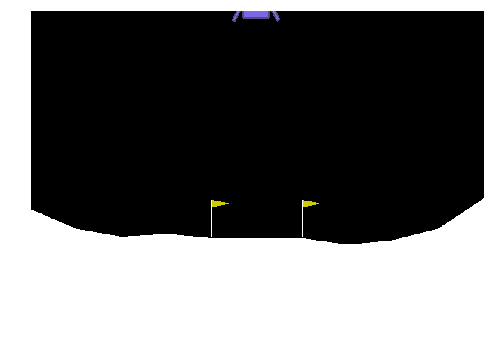

In [15]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1024, 768))
display.start()
import os
os.environ["DISPLAY"] = ":" + str(display.display) + "." + str(display.screen)

frames = []
for i in range(3):
    obs = env.reset()
    obs = obs.reshape(1,8)
    done = False
    R = 0
    t = 0
    while not done and t < 200:
        frames.append(env.render(mode = 'rgb_array'))
        action = agent.act_greedy(obs)
        obs, r, done, _ = env.step(action)
        obs = obs.reshape(1,8)
        R += r
        t += 1
    print('test episode:', i, 'R:', R)
env.render()

import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np
from IPython.display import HTML

plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
patch = plt.imshow(frames[0])
plt.axis('off')
animate = lambda i: patch.set_data(frames[i])
ani = matplotlib.animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval = 50)
HTML(ani.to_jshtml())